In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from fbg import *
from scipy.signal import find_peaks

In [2]:
filepath = 'spectra_files/psg_trn.txt'
data = psg_to_numpy(filepath, verbose=False)

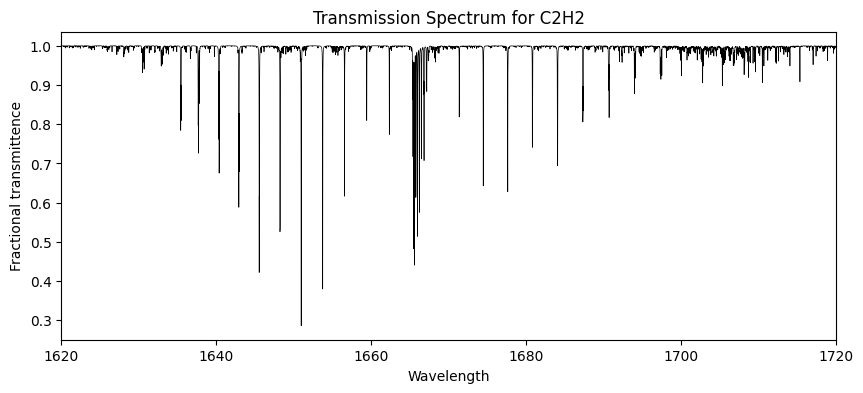

In [3]:
wavelength = data[:,0]*1e3

plt.figure(figsize=(10,4))
plt.plot(wavelength, data[:,1], color='black', linewidth=0.5)
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for C2H2')
plt.xlim((1620,1720))
plt.show()

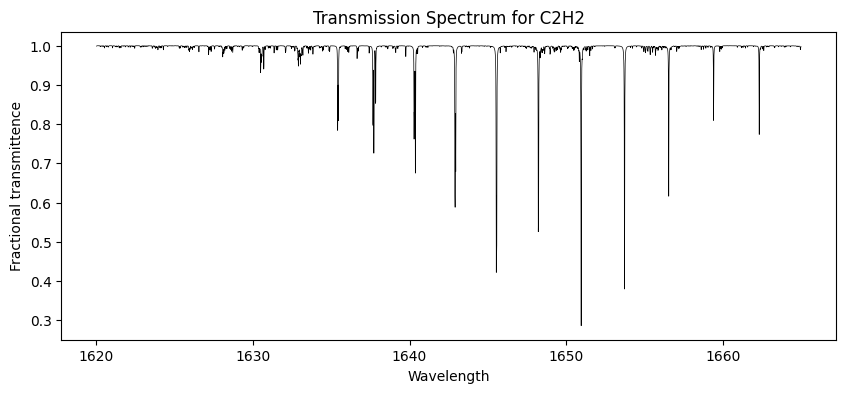

In [4]:
index_array =  np.where((wavelength>1620) & (wavelength<=1665)) # 1720
index = index_array[0]

plt.figure(figsize=(10,4))
plt.plot(wavelength[index], data[index,1], color='black', linewidth=0.5)
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for C2H2')
plt.show()

Locate peaks with minimal distance between peaks to eliminate split peaks

[1.62001  0.998889 0.998889]
[1.62001e+03 9.98889e-01 9.98889e-01]
[1.62001e+03 9.98889e-01 9.98889e-01]
1620.01


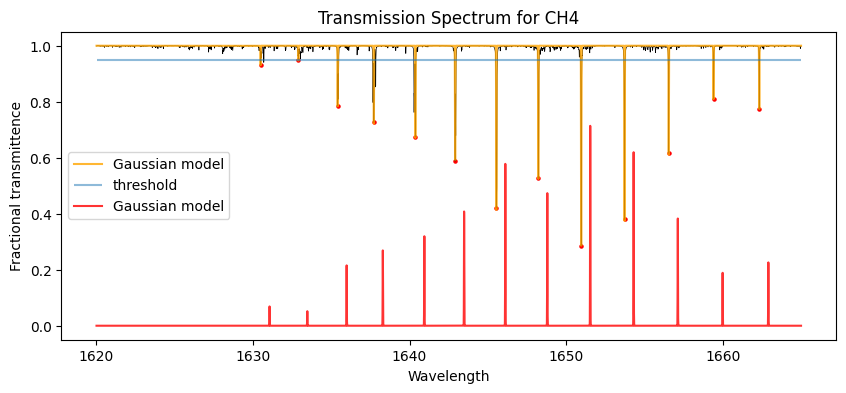

In [9]:
subset = data[index,:]
print(subset[0])

# convert wavelength into nm
subset[:,0] = subset[:,0] * 1e3


plt.show()
plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5)



threshold_value = 0.95
peaks = locate_peaks(subset[:, 1], threshold=threshold_value, distance=100) # distance=100 correspond to 1nm
wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, 0, n=10000, sigma=1e-2, type='Gaussian')
plt.scatter(subset[peaks, 0], subset[peaks, 1], color='red', s=5)
plt.plot(wavelength_gauss, trans_gauss, color='orange', alpha=0.8, label='Gaussian model')
plt.hlines(threshold_value, subset[:, 0].min(), subset[:, 0].max(), alpha=0.5, label='threshold')

print(subset[0])

# add strain
strain = 500
# new_subset = apply_strain(subset, strain)
wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, strain, n=10000, sigma=1e-2, type='Gaussian')
plt.plot(wavelength_gauss, 1-trans_gauss, color='red', alpha=0.8, label='Gaussian model')

print(subset[0])
print(wavelength_gauss[0])

plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.legend()
# plt.xlim((1620,1625))
plt.show()


Re-define function generate_spectrum_strain to include tension tuning.

Since we have $\Delta \lambda / \lambda \sim 7*10^{-1} \sigma$, where $\sigma$ is in unit of micro-strain ($\mu\epsilon$),

then, we can have $\lambda_{new} \sim (1 + 7*10^{-7} * \sigma) * \lambda$. Now, $\sigma$ is in unit of strain ($\epsilon$).

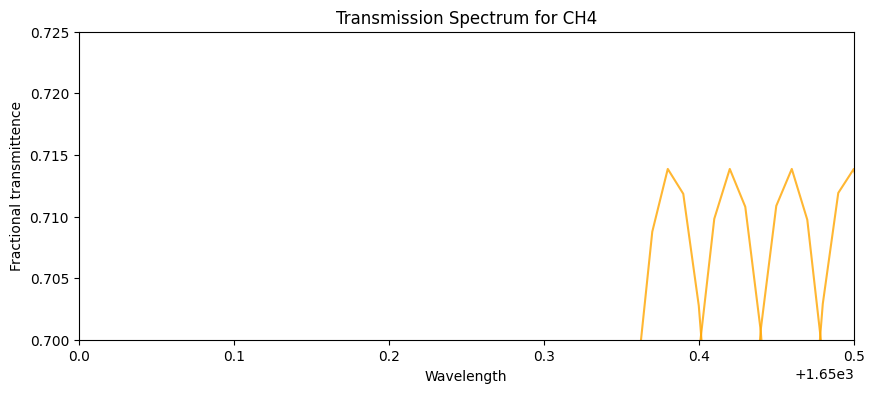

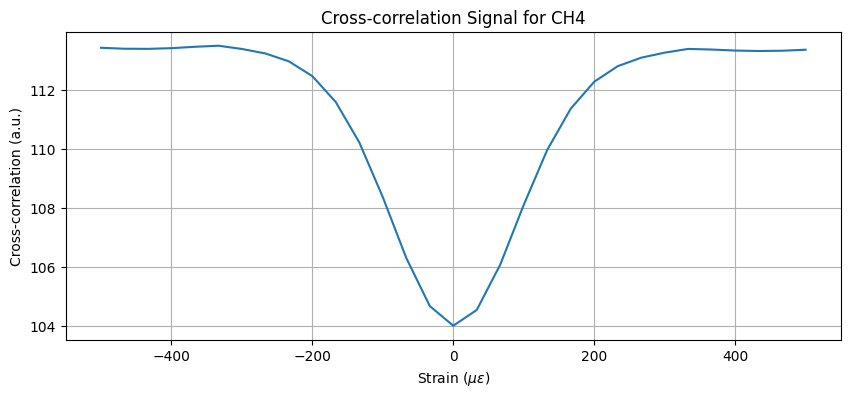

In [30]:
step = 31
strain = np.linspace(-500, 500, step)
cross_correlation = np.zeros(step)
# print(strain)

# colours = ['tab:red', 'orange', 'tab:green', 'tab:blue', 'tab:purple']
plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5, label='Original transmission spectrum')
for i in range(len(strain)): 
    # new_subset = apply_strain(subset, strain[i])
    wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, strain[i], n=len(index), sigma=1e-1, type='Gaussian')
    cross_correlation[i] = np.sum(np.multiply((1-trans_gauss), subset[:,1]))
    plt.plot(wavelength_gauss, 1-trans_gauss, color='orange', alpha=0.8, label='Gaussian model')

plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.xlim((1650.0,1650.5))
plt.ylim((0.7,0.725))
plt.show()


plt.figure(figsize=(10,4))
plt.plot(strain, cross_correlation)
plt.xlabel('Strain ($\mu\epsilon$)')
plt.ylabel('Cross-correlation (a.u.)')
plt.title('Cross-correlation Signal for CH4')
# plt.xlim((-400,-200))
# plt.ylim((56,58))
plt.grid()
plt.show()

Now, we can compute cross-correlation for different tension (strain).

In [8]:
0.1/(100 / 30000)

30.0